In [69]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D as MaxPooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, SpatialDropout2D
import six

In [70]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Resnet 34

In [162]:


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    print(stride_width, stride_height)
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    print(init_strides);
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_data_format() == 'channels_first':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        model = Model(inputs=input, outputs=block)
        return model

    @staticmethod
    def build_resnet_18(input_shape):
        return ResnetBuilder.build(input_shape, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape):
        return ResnetBuilder.build(input_shape, basic_block, [3, 4, 6, 3])

## Build U-Net Model

In [49]:
# https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/unet/models.py

def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [181]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid', name='mymodel',
               **kwargs):

    input = backbone.input
    x = backbone.output

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
    print(skip_layers)
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        if i < len(skip_layers):
#             print(backbone.layers[skip_layers[i]])
#             print(backbone.layers[skip_layers[i]].output)
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))
        print(filters)

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)
    model = Model(input, x, name=name)

    return model

In [182]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', name='mymodel', **kwargs):

    backbone = ResnetBuilder.build_resnet_34(input_shape=input_shape)

    skip_connections = list([97,54,25])  # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, name=name, **kwargs)
#     model.name = 'u-resnet34'

    return model

## Build ResNet Now

In [183]:
from tensorflow.keras.layers import add, concatenate

In [184]:
model = UResNet34(input_shape=(128,128,3), name='u-resnet34-2')

(1, 1)
1 1
(1, 1)
1 1
(1, 1)
1 1
(2, 2)
2 2
(1, 1)
1 1
(1, 1)
1 1
(1, 1)
1 1
(2, 2)
2 2
(1, 1)
1 1
(1, 1)
1 1
(1, 1)
1 1
(1, 1)
1 1
(1, 1)
1 1
(2, 2)
2 2
(1, 1)
1 1
(1, 1)
1 1
[97, 54, 25]
256
128
64
32
16


In [185]:
model.output

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'sigmoid')>

In [186]:
model.summary()

Model: "u-resnet34-2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1135 (Conv2D)            (None, 64, 64, 64)   9472        input_42[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1098 (Batch (None, 64, 64, 64)   256         conv2d_1135[0][0]                
__________________________________________________________________________________________________
activation_1030 (Activation)    (None, 64, 64, 64)   0           batch_normalization_1098[0][0]   
_______________________________________________________________________________________

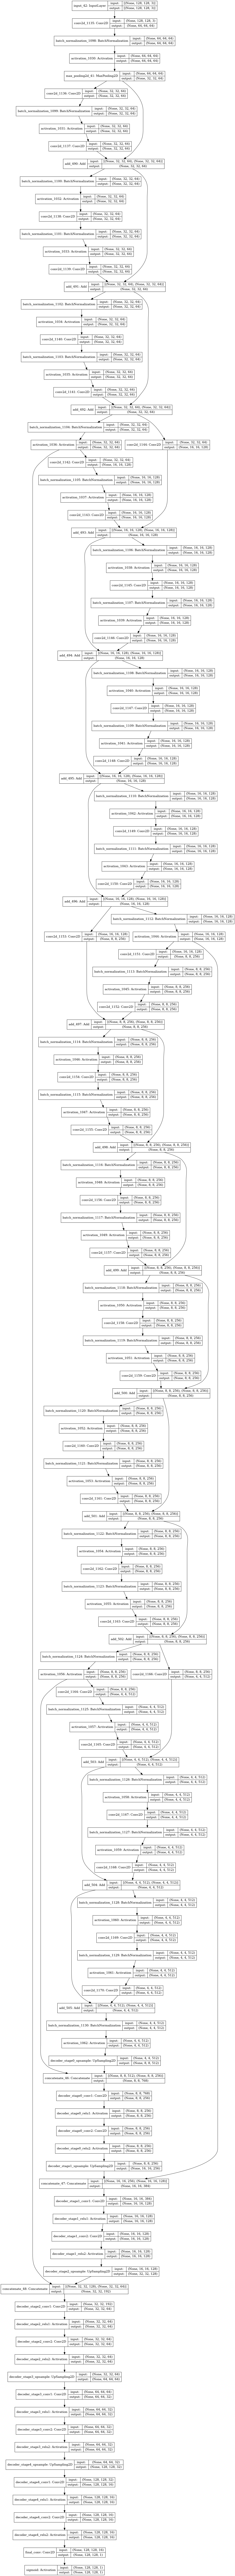

In [187]:
keras.utils.plot_model(model, show_shapes=True, to_file='resnet35-unet.png')

In [202]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [203]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['acc'])

In [204]:
# finish this later on...
import tensorflow.keras as keras
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size
    
  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 

    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
        images = []
        depths = []
        for i in range(len(rgb_files)):
            img, dpth = self.load(rgb_files[i], depth_files[i])
            images.append(img)
            depths.append(dpth)
        return np.array(images), np.array(depths)

In [205]:
# Get file names
rgb_images = os.listdir('rgb/')
rgb_images.sort()
rgb_images = [str('rgb/') + file for file in rgb_images]
depth_images = os.listdir('depth/')
depth_images.sort()
depth_images = [str('depth/') + file for file in depth_images]

test_size = 20
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(81, 128, 128, 3) (81, 128, 128)
(20, 128, 128, 3) (20, 128, 128)


In [206]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

False
False


In [207]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [209]:
model.fit(X_train, y_train, batch_size=8, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
8/8 [==============================] - 166s 46ms/step - loss: 1.0072 - acc: 0.1144 - val_loss: 1.1291 - val_acc: 0.1039
Epoch 2/50
8/8 [==============================] - 0s 40ms/step - loss: 1.0014 - acc: 0.1141 - val_loss: 1.1302 - val_acc: 0.1027
Epoch 3/50
8/8 [==============================] - 0s 41ms/step - loss: 0.9943 - acc: 0.1142 - val_loss: 1.1241 - val_acc: 0.1024
Epoch 4/50
8/8 [==============================] - 0s 40ms/step - loss: 0.9903 - acc: 0.1142 - val_loss: 1.1223 - val_acc: 0.1034
Epoch 5/50
8/8 [==============================] - 0s 40ms/step - loss: 0.9938 - acc: 0.1143 - val_loss: 1.1221 - val_acc: 0.1021
Epoch 6/50
8/8 [==============================] - 0s 39ms/step - loss: 0.9872 - acc: 0.1141 - val_loss: 1.1217 - val_acc: 0.1025
Epoch 7/50
8/8 [==============================] - 0s 40ms/step - loss: 0.9948 - acc: 0.1143 - val_loss: 1.1188 - val_acc: 0.1021
Epoch 8/50
8/8 [==============================] - 0s 40ms/step - loss: 0.9909 - acc: 0.1143 - v

In [210]:
preds = model.predict(X_test)

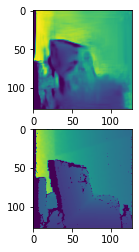

In [211]:
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)